<a href="https://colab.research.google.com/github/corentinlger/Volleyball-Pools-Optimization-/blob/main/volleyball_pools_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import random
import math
import geopy
import folium
from geopy.geocoders import Nominatim
from geopy import distance
from matplotlib import pyplot as plt 
import time 
import copy

# Préparation du jeu de données

## Initialisation des différentes villes des poules réelles 

In [ ]:
pool1 = ['Saint avertin', 'Tarascon', 'Nantes', 'Puygouzon', 'Toulouse', 'Talence', 'Balma ', 'Reze', 'Chatellerault', 'Tours', 'Montaigu Bouffere', 'Bourges']
pool2 = ['Frejus', 'Mougins', 'MARIGNANE ', 'Pradetan ', 'Arles', 'Nice', 'Ollioules ', 'MANDELIEU LA NAPOULE ', 'Martigues', 'Cannes', 'Sete', 'Antibes']
pool3 = ['THIONVILLE', 'SENNECEY ', 'ST ETIENNE', 'LYON  ', 'PAYS VOIRONNAIS ', 'RUELISHEIM', 'SAINT VITOIS ', 'LYON ', 'GERARDMER', 'KINGERSHEIM', 'DIJON', 'NANCY']
pool4 = ['ST MAUR', 'MICHELET HALLUIN ', 'AMIENS ', 'VELIZY ', 'Mouvaux ', 'Frépillon', '	CHAVILLE-SEVRES ', 'DUNKERQUE  ', 'LOGNES ', 'LAON ', 'HARNES', 'CAMBRAI']
pool5 = ['MAROMME CANTELEU', 'ROUEN  ', 'ROUEN ', '20 Rue Edouard Pailleron, 75019 Paris ', 'HEROUVILLE ', ' 92100 Boulogne-Billancourt', '	FONTENAYS ', 'cormeilles en parisis  ', 'ST-JEAN DE BRAYE ', 'CAEN  ', 'WISSOUS ', 'CHATEAUDUN ']
pool6 = ['LAVAL', '9 Rue Alphonse Baudin, 75011 Paris', 'RENNES  ', 'PARIS ', 'CESSON SEVIGNE ', 'PIPRIAC ', '	SAINT-CLOUD PARIS ', 'SAINT-BRIEUC   ', 'CLAMART ', 'MARPIRE CHAMPEAUX  ', 'BEAUNE  ', 'ORGERBLON  ']

In [ ]:
# Création d'un dataFrame pandas pour chaque poule
num_pools = 6

for i in range(1,num_pools+1):
  globals()[f'df_pool{i}'] = pd.DataFrame(globals()[f'pool{i}'], columns=['city'])
  number_of_cities = len(globals()[f'df_pool{i}'])
  print(f'Number of cities in pool{i} : {number_of_cities}')

Number of cities in pool1 : 12
Number of cities in pool2 : 12
Number of cities in pool3 : 12
Number of cities in pool4 : 12
Number of cities in pool5 : 12
Number of cities in pool6 : 12


## Création d'un dataframe contenant toutes les villes

In [ ]:
# On crée un DataFrame qui regroupe toutes les villes 

df_all_cities = pd.concat([df_pool1, df_pool2, df_pool3 , df_pool4, df_pool5, df_pool6], axis = 0)
print(f'Total number of cities : {len(df_all_cities)}')
df_all_cities.head()

Total number of cities : 72


,city
0,Saint avertin
1,Tarascon
2,Nantes
3,Puygouzon
4,Toulouse


On vérifie que l'on a pas plusieurs duplicats, sinon cela pose des problèmes dans la suite du code (par exemple si on a deux clubs situés à Paris, il faut tout de même rentrer une adresse différente)

In [ ]:
duplicate = df_all_cities[df_all_cities['city'].duplicated()]
 
print("Duplicate Rows :")
duplicate

Duplicate Rows :


,city


## Récupération des coordonnées GPS des villes 

Avec le package Nominatim, on récupère les coordonnées de chaque ville et on les affiche sur la carte de la france avec le package Folium. 

On pourra également s'en servir pour afficher la répartition finale des poules 

In [ ]:
geolocator = Nominatim(timeout=10, user_agent = "myGeolocator")
df_all_cities['gcode'] = df_all_cities['city'].apply(geolocator.geocode)
df_all_cities

,city,gcode
0,Saint avertin,"(Saint-Avertin, Arrondissement de Tours, Indre..."
1,Tarascon,"(Tarascon-sur-Ariège, Foix, Ariège, Occitanie,..."
2,Nantes,"(Nantes, Loire-Atlantique, Pays de la Loire, F..."
3,Puygouzon,"(Puygouzon, Albi, Tarn, Occitanie, France métr..."
4,Toulouse,"(Toulouse, Haute-Garonne, Occitanie, France mé..."
...,...,...
7,SAINT-BRIEUC,"(Saint-Brieuc, Côtes-d'Armor, Bretagne, France..."
8,CLAMART,"(Clamart, Antony, Hauts-de-Seine, Île-de-Franc..."
9,MARPIRE CHAMPEAUX,"(Les Landes de Marpiré, Marpiré, Fougères-Vitr..."
10,BEAUNE,"(Beaune, Côte-d'Or, Bourgogne-Franche-Comté, F..."


In [ ]:
df_all_cities['lat'] = [g.latitude for g in df_all_cities.gcode]
df_all_cities['long'] = [g.longitude for g in df_all_cities.gcode]
df_all_cities.head()

,city,gcode,lat,long
0,Saint avertin,"(Saint-Avertin, Arrondissement de Tours, Indre...",47.357700,0.739923
1,Tarascon,"(Tarascon-sur-Ariège, Foix, Ariège, Occitanie,...",42.845802,1.606759
2,Nantes,"(Nantes, Loire-Atlantique, Pays de la Loire, F...",47.218637,-1.554136
3,Puygouzon,"(Puygouzon, Albi, Tarn, Occitanie, France métr...",43.887838,2.169829
4,Toulouse,"(Toulouse, Haute-Garonne, Occitanie, France mé...",43.604462,1.444247


## Affichage sur une carte 

In [ ]:
# initialisation de la map sur la france pour afficher les villes 
mapa = folium.Map(location=(47.0000,2.0000), zoom_start=6)

# Affichage des villes 
for index, row in df_all_cities.iterrows():
  folium.Marker(location=(row['lat'],row['long'])).add_to(mapa)
display(mapa)

On voit assez facilement un grand déséquilibre spatial au niveau de la répartition des clubs sur le territoire Français métropolitain

# Initialisation de la population de chromosomes

In [ ]:
def initialize_population(nb_chromosomes = 100):
  num_pools = 6
  num_chromosomes = nb_chromosomes

  population = []

  for j in range(num_chromosomes):
    # Au début chaque poule est vide, on va ensuite utiliser ce tableau pour les remplir d'exactement 12 villes
    non_full_pools = [0,1,2,3,4,5] 
    city_per_pool = {pool: 0 for pool in range(num_pools)}
    chromosome = []
    for city in df_all_cities['city'] : 
      # On choisit une poule au hasard parmis les poules qui ne sont pas encore pleines 
      pool_choice = np.random.choice(non_full_pools)

      gene = (city, pool_choice)
      chromosome.append(gene)
      # On incrémente le compteur de villes dans cette poule et on vérifie si le nombre de villes dépasse 12
      city_per_pool[pool_choice] += 1
      # Si oui, on supprime la poule de non_full_pools pour empêcher de la choisir à nouveau  
      if city_per_pool[pool_choice] >= 12 :  
        non_full_pools.remove(pool_choice)   
    population.append(chromosome)
  
  #print(f'cities per pool : {city_per_pool}')

  return population 


In [ ]:
population = initialize_population()

In [ ]:
def show_population(population):

  print('Shape of all chromosomes : ', np.asarray(population).shape)
  print('\n')
  print('Examples of chromosomes : ')
  for i in range(5):
    print(population[i])

On a bien des population de 72 villes assignées aux 6 poules. Ces dernières sont bien aléatoires.

In [ ]:
show_population(population)

Shape of all chromosomes :  (100, 72, 2)


Examples of chromosomes : 
[('Saint avertin', 3), ('Tarascon', 5), ('Nantes', 0), ('Puygouzon', 1), ('Toulouse', 1), ('Talence', 3), ('Balma ', 3), ('Reze', 1), ('Chatellerault', 0), ('Tours', 2), ('Montaigu Bouffere', 3), ('Bourges', 0), ('Frejus', 3), ('Mougins', 0), ('MARIGNANE ', 3), ('Pradetan ', 3), ('Arles', 4), ('Nice', 2), ('Ollioules ', 3), ('MANDELIEU LA NAPOULE ', 4), ('Martigues', 2), ('Cannes', 5), ('Sete', 5), ('Antibes', 3), ('THIONVILLE', 5), ('SENNECEY ', 3), ('ST ETIENNE', 1), ('LYON  ', 4), ('PAYS VOIRONNAIS ', 3), ('RUELISHEIM', 3), ('SAINT VITOIS ', 1), ('LYON ', 4), ('GERARDMER', 5), ('KINGERSHEIM', 0), ('DIJON', 0), ('NANCY', 1), ('ST MAUR', 0), ('MICHELET HALLUIN ', 1), ('AMIENS ', 1), ('VELIZY ', 4), ('Mouvaux ', 2), ('Frépillon', 5), ('\tCHAVILLE-SEVRES ', 0), ('DUNKERQUE  ', 0), ('LOGNES ', 5), ('LAON ', 2), ('HARNES', 5), ('CAMBRAI', 5), ('MAROMME CANTELEU', 4), ('ROUEN  ', 4), ('ROUEN ', 0), ('20 Rue Edouard Paill

# Evaluation d'une population 

## Calcul des distances parcourues dans une poule 

On fait ici une grande approximation en ne prenant que la distance à vol d'oiseau. Le mieux aurait été de faire une requête pour trouver la distance de trajet / temps de trajet sur internet, car c'est cela qui nous intéresse, mais une approximation devrait fonctionner dans ce cas 


In [ ]:
def distance_coordinates(lat_a, long_a , lat_b, long_b):
    return ((lat_a-lat_b)**2+(long_a-long_b)**2)**0.5


def distance_cities(city_a, city_b, df): 
    lat_a = df_all_cities[df_all_cities['city'] == city_a]['lat'].values[0]
    long_a = df_all_cities[df_all_cities['city'] == city_a]['long'].values[0]
    lat_b = df_all_cities[df_all_cities['city'] == city_b]['lat'].values[0]
    long_b = df_all_cities[df_all_cities['city'] == city_b]['long'].values[0]
    return  distance_coordinates(lat_a, long_a , lat_b, long_b) 


In [ ]:
# Crée une matrice dans laquelle on stocke la distance entre toutes les villes 
# 72*72 distances à calculer mais pas besoin de le refaire à chaque itéreation dans la boucle finale

def calc_distance_all_cities(df) : 
  city_distance_matrix = np.zeros((72,72))
  for i in range(72): 
    for j in range(72):
      distance_i_j = distance_cities(df['city'].iloc[i], df['city'].iloc[j], df)
      city_distance_matrix [i,j] = distance_i_j
  return city_distance_matrix

## Calcul de la matrice de distances entre chaque poule

In [ ]:
st = time.time()

city_distance_matrix = calc_distance_all_cities(df_all_cities)

time.sleep(3)
et = time.time()
elapsed_time = et - st
print(f"Execution time : {elapsed_time} seconds")
print(city_distance_matrix)

Execution time : 11.563636064529419 seconds
[[0.         4.59441303 2.29827024 ... 2.21269567 4.11169094 2.49209265]
 [4.59441303 0.         5.39564141 ... 6.04886783 5.28183264 6.11697476]
 [2.29827024 5.39564141 0.         ... 0.9402215  6.39514424 0.80382827]
 ...
 [2.21269567 6.04886783 0.9402215  ... 0.         6.26953521 0.35144488]
 [4.11169094 5.28183264 6.39514424 ... 6.26953521 0.         6.57707778]
 [2.49209265 6.11697476 0.80382827 ... 0.35144488 6.57707778 0.        ]]


## Calcul de la distance à l'intérieur de chaque poule

In [ ]:
def distance_per_pool_chromosome(chromosome):
  # On crée un dictionnaire pour stocker la distance pa poule 
  total_distance = {pool: 0 for pool in range(num_pools)}
  for i, tuple_a in enumerate(chromosome):
    city_a, pool_a = tuple_a
    for j, tuple_b in enumerate(chromosome):
      city_b, pool_b = tuple_b
      # Si deux villes sont différentes et dans la même poule, on ajoute leur distance à la poule correspondante 
      if city_a != city_b and pool_a == pool_b:
        distance = city_distance_matrix[i, j]
        total_distance[pool_a] += distance
  return total_distance

In [ ]:
chromosome0 = population[0]
distance_per_pool_chromosome0 = distance_per_pool_chromosome(chromosome0)
print(distance_per_pool_chromosome0)

{0: 511.1056404076852, 1: 614.5362655215986, 2: 553.0807419418871, 3: 595.7751181960485, 4: 559.9397206028196, 5: 534.9876434729316}


## Fonction de fitness (somme des distances intra-poules)

In [ ]:
def chromosome_fitness_eval(chromosome): 
  # Calcule la somme des distances parcourue dans chaque poule
  distance_pools = distance_per_pool_chromosome(chromosome)
  total_distance = 0
  for pool_distance in distance_pools.values():
    total_distance += pool_distance 
  return total_distance

def get_all_fitness_eval(population):
  fitness_list = []
  for i, chromosome in enumerate(population) : 
    fitness = chromosome_fitness_eval(chromosome)
    fitness_list.append((i, fitness))
  return fitness_list

In [ ]:
fitness_chromosome0 = chromosome_fitness_eval(chromosome0)
print(f"fitness evaluation for chromosome0 : {fitness_chromosome0}")

fitness evaluation for chromosome0 : 3369.425130142971


In [ ]:
fitness_list = get_all_fitness_eval(population)
print(fitness_list)

[(0, 3369.425130142971), (1, 3543.774060455309), (2, 3554.3988879773415), (3, 3529.3204700006672), (4, 3368.6748625455803), (5, 3421.154187874412), (6, 3497.1338334529505), (7, 3453.633616701006), (8, 3341.3028269319484), (9, 3525.603225022787), (10, 3605.655354137551), (11, 3356.6222058415997), (12, 3475.760548330264), (13, 3190.857803019055), (14, 3568.8182950056816), (15, 3543.7418193149547), (16, 3522.1671823910724), (17, 3572.5769170719354), (18, 3499.329684429252), (19, 3511.3433212822792), (20, 3457.7009993269585), (21, 3490.0489071865863), (22, 3481.7760864891225), (23, 3388.7230201133034), (24, 3195.3899806937766), (25, 3645.2948330986), (26, 3592.4451758755804), (27, 3593.566609694625), (28, 3386.8429077095207), (29, 3554.755235024749), (30, 3526.4950637179363), (31, 3580.1577533352556), (32, 3463.3617137885576), (33, 3476.0430868202097), (34, 3614.739704954448), (35, 3501.8746993862364), (36, 3302.9562515258676), (37, 3462.0990112739196), (38, 3571.7213429905846), (39, 3526.

## Calcul de la fitness pour la configuration de poule réelle 

Cette dernière nous servira de comparaison avec les résultats de notre algotihme 

In [ ]:
real_chromosome = []
num_pools = 6
pool_counts = {i : 0 for i in range(num_pools)}

# Pour le faire on sait que les villes sont rangées par poules dans le dataFrame pandas, on les prend donc par tranches de 12
for pool_number in range(num_pools): 
  for city_number in range(12):
    idx = 12*pool_number + city_number
    real_chromosome.append((df_all_cities['city'].iloc[idx], pool_number))
    pool_counts[pool_number] +=1

print(pool_counts)
print("On vérifie qu'on a bien 12 villes par poules")
print("\n")
print("Affichage de la poule sous forme de tuple (ville, poule)")
print(real_chromosome)
print("\n")


real_distance = distance_per_pool_chromosome(real_chromosome)
print(f"Distance dans chaque poule dans la configuration réelle : {real_distance}")
total_distance = chromosome_fitness_eval(real_chromosome)
print(f"Distance totale : {total_distance}") 

{0: 12, 1: 12, 2: 12, 3: 12, 4: 12, 5: 12}
On vérifie qu'on a bien 12 villes par poules


Affichage de la poule sous forme de tuple (ville, poule)
[('Saint avertin', 0), ('Tarascon', 0), ('Nantes', 0), ('Puygouzon', 0), ('Toulouse', 0), ('Talence', 0), ('Balma ', 0), ('Reze', 0), ('Chatellerault', 0), ('Tours', 0), ('Montaigu Bouffere', 0), ('Bourges', 0), ('Frejus', 1), ('Mougins', 1), ('MARIGNANE ', 1), ('Pradetan ', 1), ('Arles', 1), ('Nice', 1), ('Ollioules ', 1), ('MANDELIEU LA NAPOULE ', 1), ('Martigues', 1), ('Cannes', 1), ('Sete', 1), ('Antibes', 1), ('THIONVILLE', 2), ('SENNECEY ', 2), ('ST ETIENNE', 2), ('LYON  ', 2), ('PAYS VOIRONNAIS ', 2), ('RUELISHEIM', 2), ('SAINT VITOIS ', 2), ('LYON ', 2), ('GERARDMER', 2), ('KINGERSHEIM', 2), ('DIJON', 2), ('NANCY', 2), ('ST MAUR', 3), ('MICHELET HALLUIN ', 3), ('AMIENS ', 3), ('VELIZY ', 3), ('Mouvaux ', 3), ('Frépillon', 3), ('\tCHAVILLE-SEVRES ', 3), ('DUNKERQUE  ', 3), ('LOGNES ', 3), ('LAON ', 3), ('HARNES', 3), ('CAMBRAI', 3), (

On voit donc que pour nous approcher d'un résultat satisfaisant par rapport à la fitness choisie, l'évaluation de notre poule finale doit avoisinner les 1600 environ. 

## Calcul et affichage des statistiques sur les fitness d'une population

In [ ]:
def get_fitness_statistics(fitness_list):
  fitness_scores_only = [fitness[1] for fitness in fitness_list]
  mean = np.mean(fitness_scores_only)
  min = np.min(fitness_scores_only)
  max = np.max(fitness_scores_only)
  return mean, min, max

In [ ]:
def show_fitness_statistics(fitness_list): 
  # On ne garde que la valeur de la distance et pas l'index du chromosome correspondant
  fitness_scores_only = [fitness[1] for fitness in fitness_list]
  mean, min, max = format(np.mean(fitness_scores_only),'.2f'), format(np.min(fitness_scores_only),'.2f'), format(np.max(fitness_scores_only),'.2f') 
  print(f' Distance moyenne : {mean}   Distance min : {min}   Distance max : {max}')

show_fitness_statistics(fitness_list)

 Distance moyenne : 3477.36   Distance min : 3190.86   Distance max : 3693.81


### Fonction de tri de la liste de fitness d'une population 

In [ ]:
def order_fitness_list(fitness_list):
  return sorted(fitness_list, key=lambda x: x[1])

In [ ]:
ordered_fitness_list = order_fitness_list(fitness_list)
print(ordered_fitness_list)

[(13, 3190.857803019055), (82, 3194.068349153388), (24, 3195.3899806937766), (77, 3209.534887814094), (41, 3293.091965076978), (64, 3294.508590279332), (36, 3302.9562515258676), (47, 3320.905579049524), (69, 3341.037957519092), (8, 3341.3028269319484), (11, 3356.6222058415997), (87, 3360.425000683098), (4, 3368.6748625455803), (0, 3369.425130142971), (94, 3372.0643635351344), (52, 3374.467851622364), (86, 3385.490346829717), (28, 3386.8429077095207), (23, 3388.7230201133034), (73, 3389.8288966757696), (55, 3390.6536058361635), (84, 3400.1337226902015), (92, 3408.7780844388553), (53, 3410.7845118732666), (5, 3421.154187874412), (96, 3424.8669396627033), (71, 3425.360436035753), (95, 3425.803731643733), (49, 3438.8176458791636), (91, 3439.140815320544), (7, 3453.633616701006), (20, 3457.7009993269585), (61, 3458.4735283980945), (54, 3461.0337578114763), (37, 3462.0990112739196), (32, 3463.3617137885576), (89, 3472.716702406083), (88, 3474.4058993378144), (79, 3474.6408058252186), (12, 34

In [ ]:
fitness_chromosome0 = chromosome_fitness_eval(chromosome0)
print(f"fitness evaluation for chromosome0 : {fitness_chromosome0}")

fitness evaluation for chromosome0 : 3369.425130142971


# Création d'une nouvelle population 

## Sélection des meilleurs chromosomes 

In [ ]:
# A chaque itération dans notre algorithme génétique, on garde les 20% des meilleurs chromosomes (=20 car on a 100 chromosomes par population)
def select_20_best_chromosomes(population, ordered_fitness_list):
  nb_of_chromosomes = 20 
  best_chromosomes_list = []
  best_chromosomes_list_idx = []
  #tuple = (population_id, fitness_score)
  for tuple in ordered_fitness_list[:nb_of_chromosomes]: 
    best_chromosomes_list.append(population[tuple[0]])
    best_chromosomes_list_idx.append(tuple[0])
  return best_chromosomes_list , best_chromosomes_list_idx
  

In [ ]:
twenty_best, idx_twenty_best = select_20_best_chromosomes(population, ordered_fitness_list)
print(f"Shape : {np.asarray(twenty_best).shape}")
print(twenty_best)
print(f"Index of the chromosomes : {idx_twenty_best}")
print(f"Index of the chromosomes : {get_all_fitness_eval(twenty_best)}")

Shape : (20, 72, 2)
[[('Saint avertin', 5), ('Tarascon', 4), ('Nantes', 2), ('Puygouzon', 5), ('Toulouse', 5), ('Talence', 5), ('Balma ', 0), ('Reze', 3), ('Chatellerault', 0), ('Tours', 4), ('Montaigu Bouffere', 1), ('Bourges', 3), ('Frejus', 0), ('Mougins', 0), ('MARIGNANE ', 5), ('Pradetan ', 1), ('Arles', 1), ('Nice', 1), ('Ollioules ', 0), ('MANDELIEU LA NAPOULE ', 4), ('Martigues', 4), ('Cannes', 1), ('Sete', 5), ('Antibes', 5), ('THIONVILLE', 0), ('SENNECEY ', 2), ('ST ETIENNE', 0), ('LYON  ', 4), ('PAYS VOIRONNAIS ', 5), ('RUELISHEIM', 5), ('SAINT VITOIS ', 5), ('LYON ', 0), ('GERARDMER', 5), ('KINGERSHEIM', 4), ('DIJON', 4), ('NANCY', 5), ('ST MAUR', 4), ('MICHELET HALLUIN ', 4), ('AMIENS ', 4), ('VELIZY ', 4), ('Mouvaux ', 1), ('Frépillon', 1), ('\tCHAVILLE-SEVRES ', 2), ('DUNKERQUE  ', 4), ('LOGNES ', 3), ('LAON ', 1), ('HARNES', 2), ('CAMBRAI', 0), ('MAROMME CANTELEU', 1), ('ROUEN  ', 0), ('ROUEN ', 0), ('20 Rue Edouard Pailleron, 75019 Paris ', 2), ('HEROUVILLE ', 1), (' 9

## Sélection des parents 

In [ ]:
# On calcule la proba pour chaque chromosome d'être parent par rapport à son rang dans la fitness_list:
def calculate_proba_parent_ordered_fitness_list(ordered_fitness_list):

  ranks = range(len(ordered_fitness_list))
  num_chromosomes = len(ordered_fitness_list)
  probabilities = [num_chromosomes - rank for rank in ranks]
  probabilities = [prob / sum(probabilities) for prob in probabilities]
  index_proba_tuples = []
  # On crée une liste avec les tuple (idx, proba_parent)
  for i in range(len(probabilities)):
    index_proba_tuples.append((ordered_fitness_list[i][0], probabilities[i]))

  # Ensuite on crée la même liste mais rangée dans l'odre des idx
  sorted_probabilities = sorted(index_proba_tuples, key=lambda x: x[0])
  # Puis on extrait uniquement les probabilités du tuple (idx, proba)
  only_probabilities = [proba for idx, proba in sorted_probabilities]

  return only_probabilities


def select_40_parents(population, probabilities) :
  # On choisit 40% de parents dans la population, en fonction des probabilitées calculées ci-dessus
  num_chromosomes = 100
  num_parents = 40

  parents = []
  parents_idx_list = []
  # On peut avoir deux fois le même parent dans la liste (aléatoire)
  for i in range(num_parents):
    parent_idx = np.random.choice(range(num_chromosomes), p=probabilities)
    parents_idx_list.append(parent_idx)
    parents.append(population[parent_idx])
  
  return parents, parents_idx_list

In [ ]:
proba_parents = calculate_proba_parent_ordered_fitness_list(ordered_fitness_list)
print(proba_parents)
print(len(proba_parents))



[0.01722772277227723, 0.004752475247524752, 0.004158415841584159, 0.006336633663366337, 0.017425742574257427, 0.015049504950495049, 0.008712871287128714, 0.013861386138613862, 0.01801980198019802, 0.006930693069306931, 0.0019801980198019802, 0.01782178217821782, 0.01207920792079208, 0.019801980198019802, 0.0037623762376237622, 0.0049504950495049506, 0.007128712871287129, 0.0031683168316831685, 0.008514851485148515, 0.0075247524752475245, 0.013663366336633663, 0.009900990099009901, 0.01089108910891089, 0.016237623762376238, 0.019405940594059406, 0.000594059405940594, 0.002376237623762376, 0.0021782178217821784, 0.016435643564356436, 0.0039603960396039604, 0.006534653465346534, 0.002772277227722772, 0.01287128712871287, 0.011881188118811881, 0.001188118811881188, 0.008118811881188119, 0.018613861386138613, 0.013069306930693069, 0.0033663366336633663, 0.006732673267326733, 0.009504950495049505, 0.01900990099009901, 0.007722772277227723, 0.005940594059405941, 0.0009900990099009901, 0.00831

In [ ]:
fourty_parents, idx_selected_parents = select_40_parents(population, proba_parents)
print(f"Selected parents shape : {np.asarray(fourty_parents).shape}")
print(f"Selected parents shape : {np.asarray(idx_selected_parents).shape}")

print(f"Selected parents : {idx_selected_parents}")
print(f"20 best chromosomes selected : {idx_twenty_best}")


Selected parents shape : (40, 72, 2)
Selected parents shape : (40,)
Selected parents : [4, 41, 23, 62, 95, 11, 73, 98, 21, 80, 49, 73, 33, 87, 78, 64, 18, 95, 78, 82, 64, 34, 50, 95, 2, 4, 7, 32, 79, 60, 23, 87, 6, 38, 65, 99, 60, 99, 28, 71]
20 best chromosomes selected : [13, 82, 24, 77, 41, 64, 36, 47, 69, 8, 11, 87, 4, 0, 94, 52, 86, 28, 23, 73]


## Mutation des parents

Après un premier test peu concluant, on fait le choix de ne pas effectuer de crossover entre différents chromosomes. En effet, le fait de fusionner des chromosomes différents n'a pas de sens au niveau des poules : la poule 1 pour un chromosome ne correspond sûrement pas du tout à la poule 1 dans un autre.

De plus, le crossover amène des problèmes car si on fusionne deux chromosomes, il faut s'assurer que le nombre de villes par poule reste bon. 

On opte donc pour l'option de la mutation interchromosome uniquement.

In [ ]:
def mutate_parent_chromosome(chromosome):
  # On fait entre 2 et 10 permutations : Le but est de modifier légèrement les chromosomes parents, car ces derniers sont susceptibles d'être relativement bonss 
  num_permutations = 2 * np.random.randint(1, 5) # On veut un multiple de 2
  permutation_indices = random.choices(range(72), k=num_permutations)
  # Echange les poules pour les gènes (=les villes) sélectionnés 
  for i in range(0, num_permutations, 2):
      gene1_index, gene2_index = permutation_indices[i], permutation_indices[i+1]
      gene1_name, gene1_value = chromosome[gene1_index]
      gene2_name, gene2_value = chromosome[gene2_index]
      chromosome[gene1_index] = (gene1_name, gene2_value)
      chromosome[gene2_index] = (gene2_name, gene1_value)
 
  return chromosome


def mutate_parent_population(parent_population):
  new_chromosomes = []
  for chromosome in parent_population : 
    mutated_chromosome1 = mutate_parent_chromosome(chromosome)
    mutated_chromosome2 = mutate_parent_chromosome(chromosome)
    new_chromosomes.append(mutated_chromosome1)
    new_chromosomes.append(mutated_chromosome2)
  return new_chromosomes

In [ ]:
chr = population[0]
print(chr)
print(mutate_parent_chromosome(chr))

[('Saint avertin', 3), ('Tarascon', 5), ('Nantes', 0), ('Puygouzon', 1), ('Toulouse', 1), ('Talence', 3), ('Balma ', 3), ('Reze', 1), ('Chatellerault', 0), ('Tours', 2), ('Montaigu Bouffere', 3), ('Bourges', 0), ('Frejus', 3), ('Mougins', 0), ('MARIGNANE ', 3), ('Pradetan ', 3), ('Arles', 4), ('Nice', 2), ('Ollioules ', 3), ('MANDELIEU LA NAPOULE ', 4), ('Martigues', 2), ('Cannes', 5), ('Sete', 5), ('Antibes', 3), ('THIONVILLE', 5), ('SENNECEY ', 3), ('ST ETIENNE', 1), ('LYON  ', 4), ('PAYS VOIRONNAIS ', 3), ('RUELISHEIM', 3), ('SAINT VITOIS ', 1), ('LYON ', 4), ('GERARDMER', 5), ('KINGERSHEIM', 0), ('DIJON', 0), ('NANCY', 1), ('ST MAUR', 0), ('MICHELET HALLUIN ', 1), ('AMIENS ', 1), ('VELIZY ', 4), ('Mouvaux ', 2), ('Frépillon', 5), ('\tCHAVILLE-SEVRES ', 0), ('DUNKERQUE  ', 0), ('LOGNES ', 5), ('LAON ', 2), ('HARNES', 5), ('CAMBRAI', 5), ('MAROMME CANTELEU', 4), ('ROUEN  ', 4), ('ROUEN ', 0), ('20 Rue Edouard Pailleron, 75019 Paris ', 0), ('HEROUVILLE ', 5), (' 92100 Boulogne-Billanc

In [ ]:
children_population = mutate_parent_population(fourty_parents)
print(np.asarray(children_population).shape)
print(children_population)

(80, 72, 2)
[[('Saint avertin', 0), ('Tarascon', 0), ('Nantes', 1), ('Puygouzon', 0), ('Toulouse', 4), ('Talence', 2), ('Balma ', 0), ('Reze', 0), ('Chatellerault', 1), ('Tours', 4), ('Montaigu Bouffere', 2), ('Bourges', 1), ('Frejus', 1), ('Mougins', 3), ('MARIGNANE ', 4), ('Pradetan ', 5), ('Arles', 2), ('Nice', 3), ('Ollioules ', 3), ('MANDELIEU LA NAPOULE ', 1), ('Martigues', 3), ('Cannes', 3), ('Sete', 1), ('Antibes', 1), ('THIONVILLE', 4), ('SENNECEY ', 2), ('ST ETIENNE', 5), ('LYON  ', 4), ('PAYS VOIRONNAIS ', 4), ('RUELISHEIM', 0), ('SAINT VITOIS ', 1), ('LYON ', 2), ('GERARDMER', 3), ('KINGERSHEIM', 4), ('DIJON', 4), ('NANCY', 1), ('ST MAUR', 2), ('MICHELET HALLUIN ', 2), ('AMIENS ', 0), ('VELIZY ', 4), ('Mouvaux ', 1), ('Frépillon', 2), ('\tCHAVILLE-SEVRES ', 3), ('DUNKERQUE  ', 4), ('LOGNES ', 4), ('LAON ', 0), ('HARNES', 0), ('CAMBRAI', 4), ('MAROMME CANTELEU', 3), ('ROUEN  ', 0), ('ROUEN ', 2), ('20 Rue Edouard Pailleron, 75019 Paris ', 5), ('HEROUVILLE ', 0), (' 92100 Bou

## Fusion des meilleurs chromosomes et des chromosomes mutés

In [ ]:
def create_new_population(twenty_best_chromosomes, mutated_chromosomes):
  new_population = twenty_best_chromosomes + mutated_chromosomes
  return new_population

In [ ]:
print(f"fit 20 best : {get_all_fitness_eval(twenty_best)}")
print(f"fit eval chiild : {get_all_fitness_eval(children_population)}")

new_population = create_new_population(twenty_best, children_population )
print(f"fit eval new pop : {get_all_fitness_eval(new_population)}")


fit 20 best : [(0, 3190.857803019055), (1, 3166.370565319554), (2, 3195.3899806937766), (3, 3209.534887814094), (4, 3271.238964199553), (5, 3446.721584823539), (6, 3302.9562515258676), (7, 3320.905579049524), (8, 3341.037957519092), (9, 3341.3028269319484), (10, 3377.7948572566506), (11, 3456.192515968309), (12, 3457.765516422214), (13, 3313.70707672059), (14, 3372.0643635351344), (15, 3374.467851622364), (16, 3385.490346829717), (17, 3356.319860449961), (18, 3613.9036847529846), (19, 3462.0809893669084)]
fit eval chiild : [(0, 3457.765516422214), (1, 3457.765516422214), (2, 3271.238964199553), (3, 3271.238964199553), (4, 3613.9036847529846), (5, 3613.9036847529846), (6, 3621.449117029128), (7, 3621.449117029128), (8, 3425.945207673492), (9, 3425.945207673492), (10, 3377.7948572566506), (11, 3377.7948572566506), (12, 3462.0809893669084), (13, 3462.0809893669084), (14, 3496.6848049178634), (15, 3496.6848049178634), (16, 3605.608048398637), (17, 3605.608048398637), (18, 3506.642703165018

# Boucle principale

In [ ]:
num_iterations = 40000
measurement_step = 500
mean_distance = []
min_distance = []
max_distance = []


st = time.time()

for i in range(num_iterations): 
  
  population_fitness_list = get_all_fitness_eval(new_population)
  #print(f"Population fitness list : {population_fitness_list}")
  ordered_fitness_list = order_fitness_list(population_fitness_list)
  #print(f"Population ordered fitness list : {ordered_fitness_list}")

  if i % measurement_step == 0:
    print("\n")
    print(f"Iteration {i}")
    show_fitness_statistics(population_fitness_list)
    mean, min, max = get_fitness_statistics(population_fitness_list)
    mean_distance.append(mean)
    min_distance.append(min)
    max_distance.append(max)

  # On crée notre nouvelle population 

  # 1 - Les 20 meilleurs éléments :
  twenty_best_chromosomes, twenty_best_chromosomes_idx = select_20_best_chromosomes(new_population, ordered_fitness_list)
  #print('twenty best fitness : ', get_all_fitness_eval(twenty_best_chromosomes))
 

  # 2 - Les enfants issus des parents : 
  parents_proba = calculate_proba_parent_ordered_fitness_list(ordered_fitness_list)
  parents, parents_idx = select_40_parents(new_population, parents_proba)
  children = mutate_parent_population(copy.deepcopy(parents))
  #print('children fitness : ', get_all_fitness_eval(children))

  new_population = create_new_population(twenty_best_chromosomes, children )
 
  
# Affichage des statistiques et du chromosome pour le meilleur chromosome trouvé : 

print("\n")
print('Best chromosome :')
last_population_fitness_list = get_all_fitness_eval(new_population)
last_ordered_fitness_list = order_fitness_list(last_population_fitness_list)
best_chromosome_idx = last_ordered_fitness_list[0][0]
best_chromsome = new_population[best_chromosome_idx]
print(f"{best_chromsome}" )
print(f"Best chromosome distance per pool : {distance_per_pool_chromosome(best_chromsome)}" )
print(f"Best chromosome : {chromosome_fitness_eval(best_chromsome)}" )


# Mesure du temps de calcul
time.sleep(3)
et = time.time()
elapsed_time = et - st
print(f"Execution time : {elapsed_time} seconds")




Iteration 0
 Distance moyenne : 3454.03   Distance min : 3166.37   Distance max : 3636.54


Iteration 500
 Distance moyenne : 3073.99   Distance min : 2357.74   Distance max : 3505.27


Iteration 1000
 Distance moyenne : 2956.27   Distance min : 2231.10   Distance max : 3474.59


Iteration 1500
 Distance moyenne : 2797.69   Distance min : 2020.91   Distance max : 3479.71


Iteration 2000
 Distance moyenne : 2768.16   Distance min : 1934.84   Distance max : 3378.77


Iteration 2500
 Distance moyenne : 2738.02   Distance min : 1878.60   Distance max : 3349.69


Iteration 3000
 Distance moyenne : 2831.13   Distance min : 1788.44   Distance max : 3622.78


Iteration 3500
 Distance moyenne : 2723.18   Distance min : 1669.05   Distance max : 3437.82


Iteration 4000
 Distance moyenne : 2620.32   Distance min : 1665.30   Distance max : 3473.59


Iteration 4500
 Distance moyenne : 2548.16   Distance min : 1601.23   Distance max : 3512.67


Iteration 5000
 Distance moyenne : 2652.49   Distanc

## Evolution des statistiques de fitness par itérations 

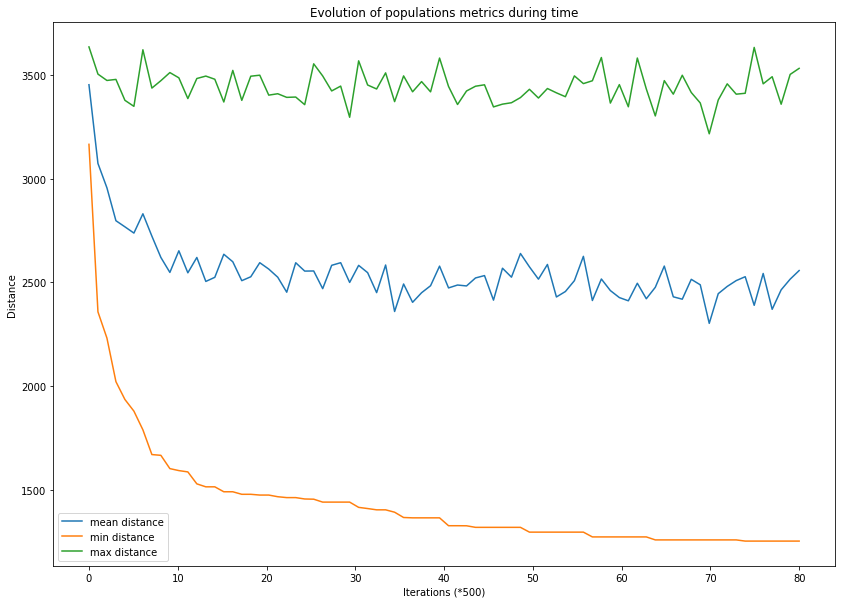

In [ ]:
nb_measures = num_iterations//measurement_step
x = np.linspace(0, nb_measures, num=nb_measures)
plt.figure(figsize=(14,10))
plt.plot(x, mean_distance, label='mean distance')
plt.plot(x, min_distance, label='min distance')
plt.plot(x, max_distance, label='max distance')
plt.legend()
plt.xlabel('Iterations (*500)')
plt.ylabel('Distance')
plt.title('Evolution of populations metrics during time')
plt.show()



In [ ]:
print(best_chromsome)

[('Saint avertin', 4), ('Tarascon', 4), ('Nantes', 2), ('Puygouzon', 4), ('Toulouse', 4), ('Talence', 4), ('Balma ', 4), ('Reze', 2), ('Chatellerault', 4), ('Tours', 2), ('Montaigu Bouffere', 2), ('Bourges', 4), ('Frejus', 0), ('Mougins', 0), ('MARIGNANE ', 0), ('Pradetan ', 0), ('Arles', 0), ('Nice', 0), ('Ollioules ', 0), ('MANDELIEU LA NAPOULE ', 0), ('Martigues', 0), ('Cannes', 0), ('Sete', 0), ('Antibes', 0), ('THIONVILLE', 3), ('SENNECEY ', 5), ('ST ETIENNE', 5), ('LYON  ', 5), ('PAYS VOIRONNAIS ', 5), ('RUELISHEIM', 5), ('SAINT VITOIS ', 5), ('LYON ', 5), ('GERARDMER', 5), ('KINGERSHEIM', 5), ('DIJON', 5), ('NANCY', 5), ('ST MAUR', 3), ('MICHELET HALLUIN ', 3), ('AMIENS ', 3), ('VELIZY ', 1), ('Mouvaux ', 3), ('Frépillon', 1), ('\tCHAVILLE-SEVRES ', 1), ('DUNKERQUE  ', 3), ('LOGNES ', 1), ('LAON ', 3), ('HARNES', 3), ('CAMBRAI', 3), ('MAROMME CANTELEU', 4), ('ROUEN  ', 3), ('ROUEN ', 3), ('20 Rue Edouard Pailleron, 75019 Paris ', 1), ('HEROUVILLE ', 3), (' 92100 Boulogne-Billanc

# Affichage des poules finales sur une carte

In [ ]:
map = folium.Map(location=(47.0000,2.0000), zoom_start=6)
colors = ['blue', 'green', 'purple', 'orange', 'darkred', 'lightred']
# Affichage des villes 
for index, tuple in enumerate(best_chromsome):
  latitude, longitude = df_all_cities.iloc[index,2], df_all_cities.iloc[index,3]
  folium.Marker(location=(latitude, longitude), icon=folium.Icon(color=colors[tuple[1]])).add_to(map)

display(map)

# Résultats :

On obtient une très bon résultat au vu de la fonction de fitness choisie, et ce même par rapport à la configuration de poules réelle. Cependant, la répartition des villes dans les poules trouvée crée de très grand déséquilibre de déplacements. On peut par exemple comparer la poule parisienne, qui est très compacte, à celle de Bordeaux où les déplacements sotn extrêmement longs. 

Une nouvelle fonction de fitness est donc à trouver, et la vitesse d'exécution de l'algorithme doit elle aussi être améliorée, notamment en optimisant le calcul de fitness réalisé à chaque itération.